In [ ]:
!pip install requests pandas numpy scikit-learn spacy bertopic umap-learn hdbscan matplotlib
!python -m spacy download en_core_web_sm

import requests
import pandas as pd
import numpy as np
import re
import spacy
import xml.etree.ElementTree as ET
from bertopic import BERTopic
import time

nlp = spacy.load("en_core_web_sm")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 30.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
# Your topics of interest
topics = [
    "biomedical informatics",
    "CRISPR gene editing",
    "blockchain in healthcare",
    "AI ethics in medicine",
    "synthetic biology",
    "medical imaging",
    "Precision Oncology",
    "Genomic Medicine"

]

# Fetch arXiv papers
def fetch_arxiv(query, max_results=100):
    url = f"http://export.arxiv.org/api/query?search_query=all:{query}&start=0&max_results={max_results}"
    response = requests.get(url)
    papers = []
    if response.status_code == 200:
        root = ET.fromstring(response.text)
        for entry in root.findall("{http://www.w3.org/2005/Atom}entry"):
            title = entry.find("{http://www.w3.org/2005/Atom}title").text or ''
            abstract = entry.find("{http://www.w3.org/2005/Atom}summary").text or ''
            published = entry.find("{http://www.w3.org/2005/Atom}published").text or ''
            papers.append({'title': title.strip(), 'abstract': abstract.strip(), 'published_date': published, 'source': 'arXiv'})
    return papers

# Fetch PubMed papers
def fetch_pubmed(query, retmax=100):
    search_url = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi"
    fetch_url = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi"
    params_search = {
        "db": "pubmed",
        "term": query,
        "retmax": retmax,
        "retmode": "json"
    }
    resp = requests.get(search_url, params=params_search)
    papers = []
    if resp.status_code == 200:
        pmids = resp.json().get('esearchresult', {}).get('idlist', [])
        if pmids:
            params_fetch = {
                "db": "pubmed",
                "retmode": "xml",
                "id": ",".join(pmids)
            }
            fetch_resp = requests.get(fetch_url, params=params_fetch)
            if fetch_resp.status_code == 200:
                root = ET.fromstring(fetch_resp.text)
                for article in root.findall(".//PubmedArticle"):
                    title_elem = article.find(".//ArticleTitle")
                    abstract_elem = article.find(".//AbstractText")
                    pubdate_elem = article.find(".//PubDate/Year")
                    # Handle potential None values and strip text if present
                    title = title_elem.text.strip() if title_elem is not None and title_elem.text is not None else ""
                    abstract = abstract_elem.text.strip() if abstract_elem is not None and abstract_elem.text is not None else "No abstract"
                    published_date = pubdate_elem.text.strip() if pubdate_elem is not None and pubdate_elem.text is not None else "No date"
                    papers.append({'title': title, 'abstract': abstract, 'published_date': published_date, 'source': 'PubMed'})
    return papers

# Fetch CrossRef papers
def fetch_crossref(query, rows=100):
    url = "https://api.crossref.org/works"
    params = {
        "query": query,
        "rows": rows
    }
    resp = requests.get(url, params=params)
    papers = []
    if resp.status_code == 200:
        items = resp.json().get('message', {}).get('items', [])
        for item in items:
            title_list = item.get('title', [])
            title = title_list[0] if title_list else ""
            abstract = item.get('abstract', "No abstract")
            # Clean HTML tags in CrossRef abstracts (if any)
            if abstract and isinstance(abstract, str):
                abstract = re.sub(r'<.*?>', '', abstract)
            pub_date_parts = item.get('published-print', {}).get('date-parts', [[]])
            published_date = str(pub_date_parts[0][0]) if pub_date_parts and pub_date_parts[0] else "No date"
            papers.append({'title': title.strip(), 'abstract': abstract.strip() if abstract else "No abstract", 'published_date': published_date, 'source':'CrossRef'})
    return papers

In [ ]:
all_papers = []

for topic in topics:
    print(f"Fetching papers for topic: {topic}")
    arxiv_papers = fetch_arxiv(topic, max_results=100)
    all_papers.extend(arxiv_papers)
    time.sleep(1)

    pubmed_papers = fetch_pubmed(topic, retmax=100)
    all_papers.extend(pubmed_papers)
    time.sleep(1)

    crossref_papers = fetch_crossref(topic, rows=100)
    all_papers.extend(crossref_papers)
    time.sleep(1)

print(f"Total papers collected: {len(all_papers)}")
papers_df = pd.DataFrame(all_papers)


Fetching papers for topic: biomedical informatics
Fetching papers for topic: CRISPR gene editing
Fetching papers for topic: blockchain in healthcare
Fetching papers for topic: AI ethics in medicine
Fetching papers for topic: synthetic biology
Fetching papers for topic: medical imaging
Fetching papers for topic: Precision Oncology
Fetching papers for topic: Genomic Medicine
Total papers collected: 2220


In [ ]:
def preprocess_text(text):
    if not isinstance(text, str) or len(text) == 0:
        return ""
    doc = nlp(text.lower())
    tokens = [token.lemma_ for token in doc if token.is_alpha and not token.is_stop]
    return " ".join(tokens)

papers_df['processed_text'] = papers_df['abstract'].apply(preprocess_text)


In [ ]:
topic_model = BERTopic(min_topic_size=10, nr_topics="auto")
docs = papers_df['processed_text'].tolist()

topics, probs = topic_model.fit_transform(docs)
papers_df['topic'] = topics

print(topic_model.get_topic_info().head())

# Optional visualization
if len(topic_model.get_topic_info()) > 1:
    topic_model.visualize_topics()
else:
    print("Not enough topics generated for visualization.")


   Topic  Count                                  Name  \
0     -1    425             -1_model_cell_gene_cancer   
1      0    603                         0_abstract___   
2      1    151         1_datum_biomedical_genomic_ai   
3      2    137  2_image_medical_segmentation_imaging   
4      3    132          3_crispr_editing_gene_system   

                                      Representation  \
0  [model, cell, gene, cancer, study, patient, da...   
1                       [abstract, , , , , , , , , ]   
2  [datum, biomedical, genomic, ai, medicine, res...   
3  [image, medical, segmentation, imaging, model,...   
4  [crispr, editing, gene, system, cas, target, g...   

                                 Representative_Docs  
0  [generative artificial intelligence ai model d...  
1                     [abstract, abstract, abstract]  
2  [precision medicine tailor individual patient ...  
3  [generative adversarial network gan unsupervis...  
4  [type crispr cas system common type crispr

In [ ]:
topic_model.visualize_topics()

In [ ]:
# Get topic information
topic_info = topic_model.get_topic_info()

# Display all topic names
print("Topic Names:")
print(topic_info['Name'])

Topic Names:
0                    -1_model_cell_gene_cancer
1                                0_abstract___
2                1_datum_biomedical_genomic_ai
3         2_image_medical_segmentation_imaging
4                 3_crispr_editing_gene_system
5     4_blockchain_healthcare_datum_technology
6             5_tumor_cancer_oncology_survival
7                 6_ai_ethic_ethical_principle
8              7_synthetic_biology_design_cell
9                  8_fracture_ct_robotic_fiber
10                  9_cause_health_disease_gbd
11              10_dose_trial_treatment_effect
12              11_ad_brain_cognitive_boundary
13                     12_sleep_ecg_eat_method
14                              13_abstract___
15     14_siderophore_plant_compound_microbial
16        15_quantum_classical_state_algorithm
17                16_virus_viral_hiv_telsvirus
18                   17_tree_gene_graph_specie
Name: Name, dtype: object


In [ ]:
import pandas as pd
from dateutil import parser

def extract_year(date_str):
    try:
        dt = parser.parse(date_str)
        return dt.year
    except:
        return None

papers_df['year'] = papers_df['published_date'].apply(extract_year)
papers_df = papers_df.dropna(subset=['year'])
papers_df['year'] = papers_df['year'].astype(int)

print(f"Paper counts by year: \n{papers_df['year'].value_counts().sort_index()}")


Paper counts by year: 
year
1982      4
1983      4
1984      4
1985      4
1986      4
1987      5
1989     11
1990      3
1991      2
1992      3
1997      1
1998      1
2001      2
2002      2
2003      1
2004     20
2005      2
2006     16
2007     13
2008      3
2009     35
2010     22
2011     17
2012     12
2013     41
2014     44
2015     25
2016     34
2017     49
2018     53
2019     95
2020     91
2021    104
2022    108
2023    134
2024    164
2025    904
2026      7
Name: count, dtype: int64


In [ ]:
# Group by year and topic, count papers
topic_year_freq = papers_df.groupby(['year', 'topic']).size().unstack(fill_value=0)

# Rank topics by frequency in each year (1 = most frequent)
topic_year_rank = topic_year_freq.rank(axis=1, method='min', ascending=False)

print("Sample topic frequencies by year:")
print(topic_year_freq.head())

print("Sample topic ranks by year:")
print(topic_year_rank.head())


Sample topic frequencies by year:
topic  -1    0    1    2    3    4    5    6    7    8   ...   11   12   13  \
year                                                     ...                  
1982     0    4    0    0    0    0    0    0    0    0  ...    0    0    0   
1983     0    4    0    0    0    0    0    0    0    0  ...    0    0    0   
1984     0    4    0    0    0    0    0    0    0    0  ...    0    0    0   
1985     0    4    0    0    0    0    0    0    0    0  ...    0    0    0   
1986     0    4    0    0    0    0    0    0    0    0  ...    0    0    0   

topic   14   15   16   17   18   19   20  
year                                      
1982     0    0    0    0    0    0    0  
1983     0    0    0    0    0    0    0  
1984     0    0    0    0    0    0    0  
1985     0    0    0    0    0    0    0  
1986     0    0    0    0    0    0    0  

[5 rows x 22 columns]
Sample topic ranks by year:
topic  -1    0    1    2    3    4    5    6    7    8   ...

In [ ]:
# Calculate absolute difference of ranks year over year
topic_rank_diff = topic_year_rank.diff().abs()

# Mean volatility per topic over all years
volatility_scores = topic_rank_diff.mean()

# Top 10 most volatile topics
top_volatile = volatility_scores.sort_values(ascending=False).head(10)
print("Top 10 volatile topics:")
print(top_volatile)


Top 10 volatile topics:
topic
13    2.189189
15    2.027027
20    1.918919
6     1.918919
8     1.864865
18    1.756757
16    1.702703
9     1.702703
11    1.702703
17    1.648649
dtype: float64


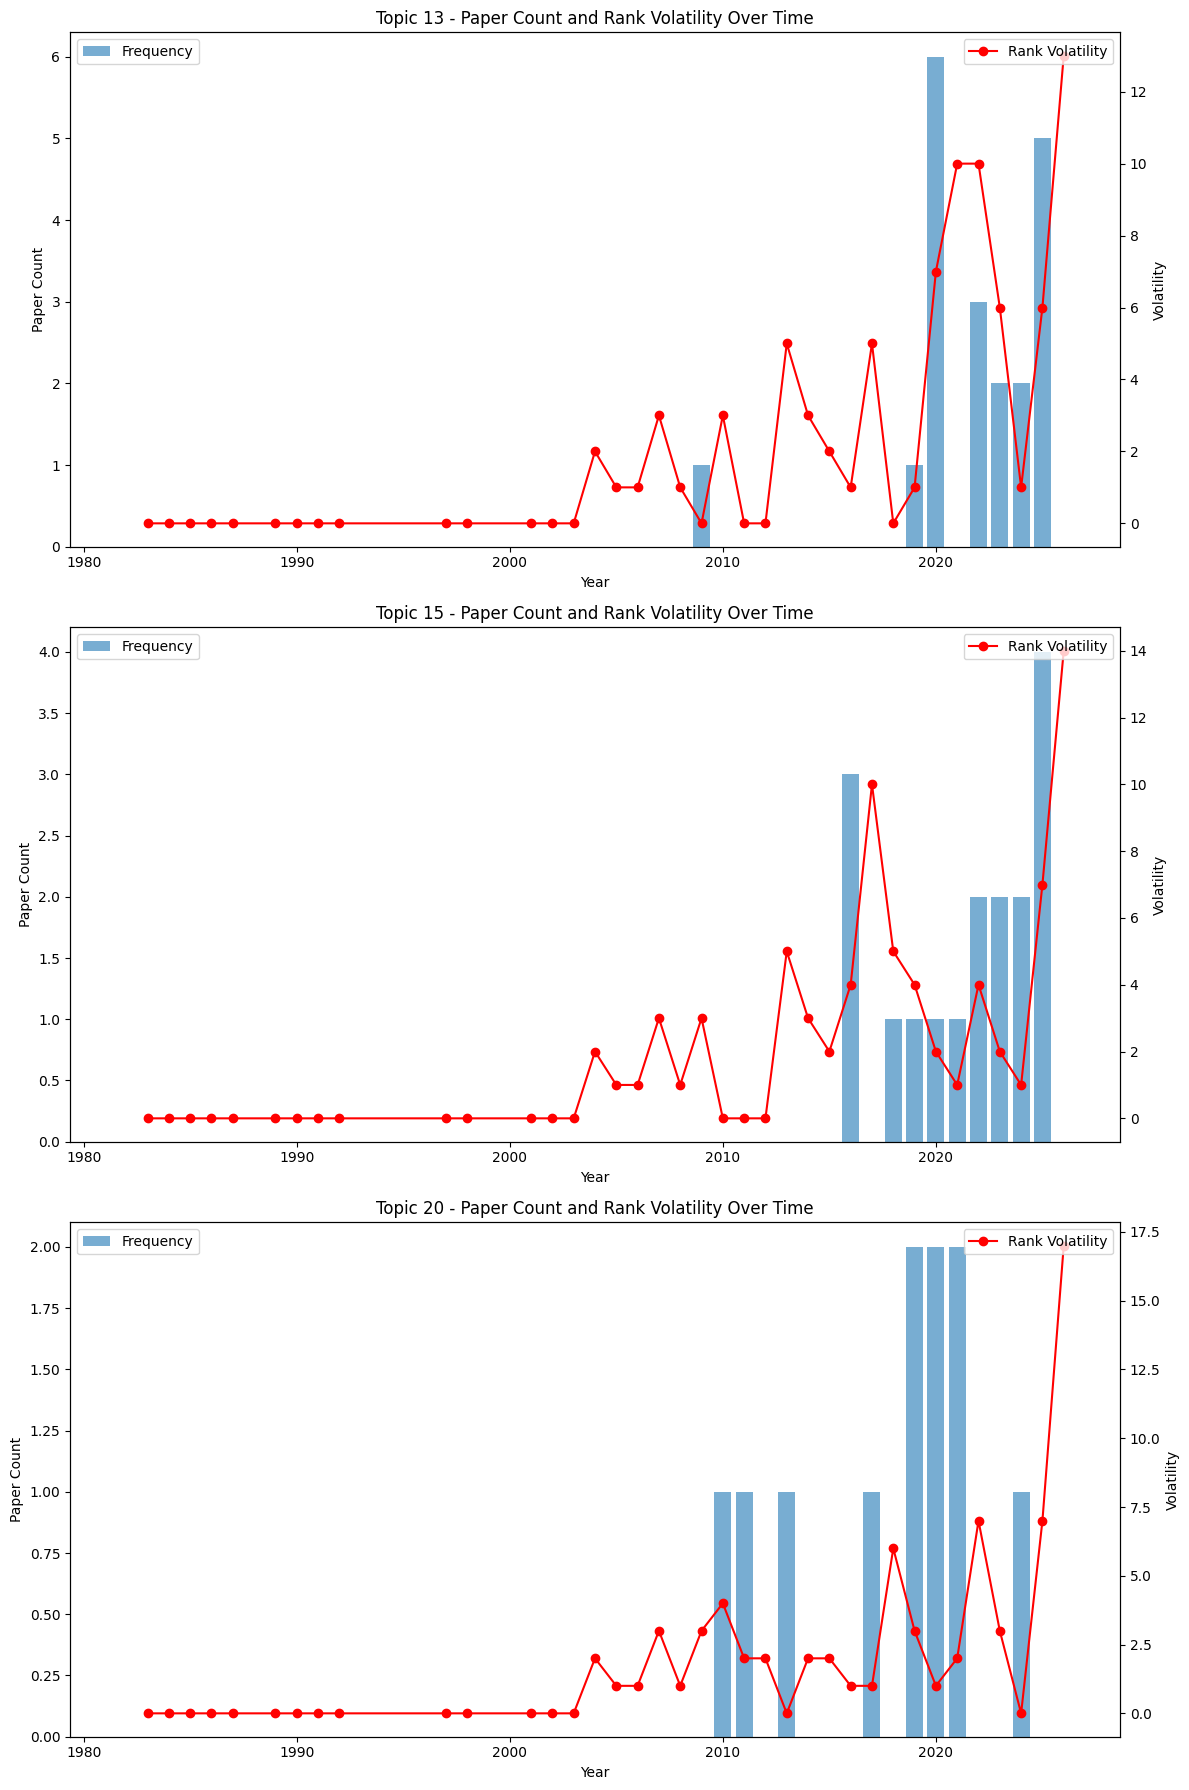

In [ ]:
import matplotlib.pyplot as plt

selected_topics = top_volatile.index[:3]

fig, axes = plt.subplots(len(selected_topics), 1, figsize=(12, 6*len(selected_topics)))

if len(selected_topics) == 1:
    axes = [axes]

for ax, topic in zip(axes, selected_topics):
    ax.bar(topic_year_freq.index, topic_year_freq[topic], alpha=0.6, label='Frequency')
    ax.set_xlabel('Year')
    ax.set_ylabel('Paper Count')
    ax.set_title(f'Topic {topic} - Paper Count and Rank Volatility Over Time')

    ax2 = ax.twinx()
    ax2.plot(topic_rank_diff.index, topic_rank_diff[topic], 'r-o', label='Rank Volatility')
    ax2.set_ylabel('Volatility')

    ax.legend(loc='upper left')
    ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
from dateutil import parser

def extract_year(date_str):
    try:
        dt = parser.parse(date_str)
        return dt.year
    except:
        return None

papers_df['year'] = papers_df['published_date'].apply(extract_year)

# Drop papers with unknown year
papers_df = papers_df.dropna(subset=['year'])
papers_df['year'] = papers_df['year'].astype(int)

print(f"Papers count by year:\n{papers_df['year'].value_counts().sort_index()}")


Papers count by year:
year
1982      4
1983      4
1984      4
1985      4
1986      4
1987      5
1989     11
1990      3
1991      2
1992      3
1997      1
1998      1
2001      2
2002      2
2003      1
2004     20
2005      2
2006     16
2007     13
2008      3
2009     35
2010     22
2011     17
2012     12
2013     41
2014     44
2015     25
2016     34
2017     49
2018     53
2019     95
2020     91
2021    104
2022    108
2023    134
2024    164
2025    904
2026      7
Name: count, dtype: int64


In [ ]:
# Count papers per topic per year
topic_year_counts = papers_df.groupby(['year', 'topic']).size().unstack(fill_value=0)

# Rank topics by frequency per year (1 = highest frequency)
topic_year_ranks = topic_year_counts.rank(axis=1, method='min', ascending=False)

print("Topic frequency by year (sample):")
print(topic_year_counts.head())
print("Topic rank by year (sample):")
print(topic_year_ranks.head())


Topic frequency by year (sample):
topic  -1    0    1    2    3    4    5    6    7    8   ...   11   12   13  \
year                                                     ...                  
1982     0    4    0    0    0    0    0    0    0    0  ...    0    0    0   
1983     0    4    0    0    0    0    0    0    0    0  ...    0    0    0   
1984     0    4    0    0    0    0    0    0    0    0  ...    0    0    0   
1985     0    4    0    0    0    0    0    0    0    0  ...    0    0    0   
1986     0    4    0    0    0    0    0    0    0    0  ...    0    0    0   

topic   14   15   16   17   18   19   20  
year                                      
1982     0    0    0    0    0    0    0  
1983     0    0    0    0    0    0    0  
1984     0    0    0    0    0    0    0  
1985     0    0    0    0    0    0    0  
1986     0    0    0    0    0    0    0  

[5 rows x 22 columns]
Topic rank by year (sample):
topic  -1    0    1    2    3    4    5    6    7    8   ..

In [ ]:
# Compute absolute differences between consecutive years' topic ranks
topic_rank_diff = topic_year_ranks.diff().abs()

# Calculate mean volatility for each topic over years
topic_volatility = topic_rank_diff.mean()

# Display top 10 most volatile topics
most_volatile = topic_volatility.sort_values(ascending=False).head(10)
print("Top 10 most volatile topics by mean rank change:")
print(most_volatile)


Top 10 most volatile topics by mean rank change:
topic
13    2.189189
15    2.027027
20    1.918919
6     1.918919
8     1.864865
18    1.756757
16    1.702703
9     1.702703
11    1.702703
17    1.648649
dtype: float64


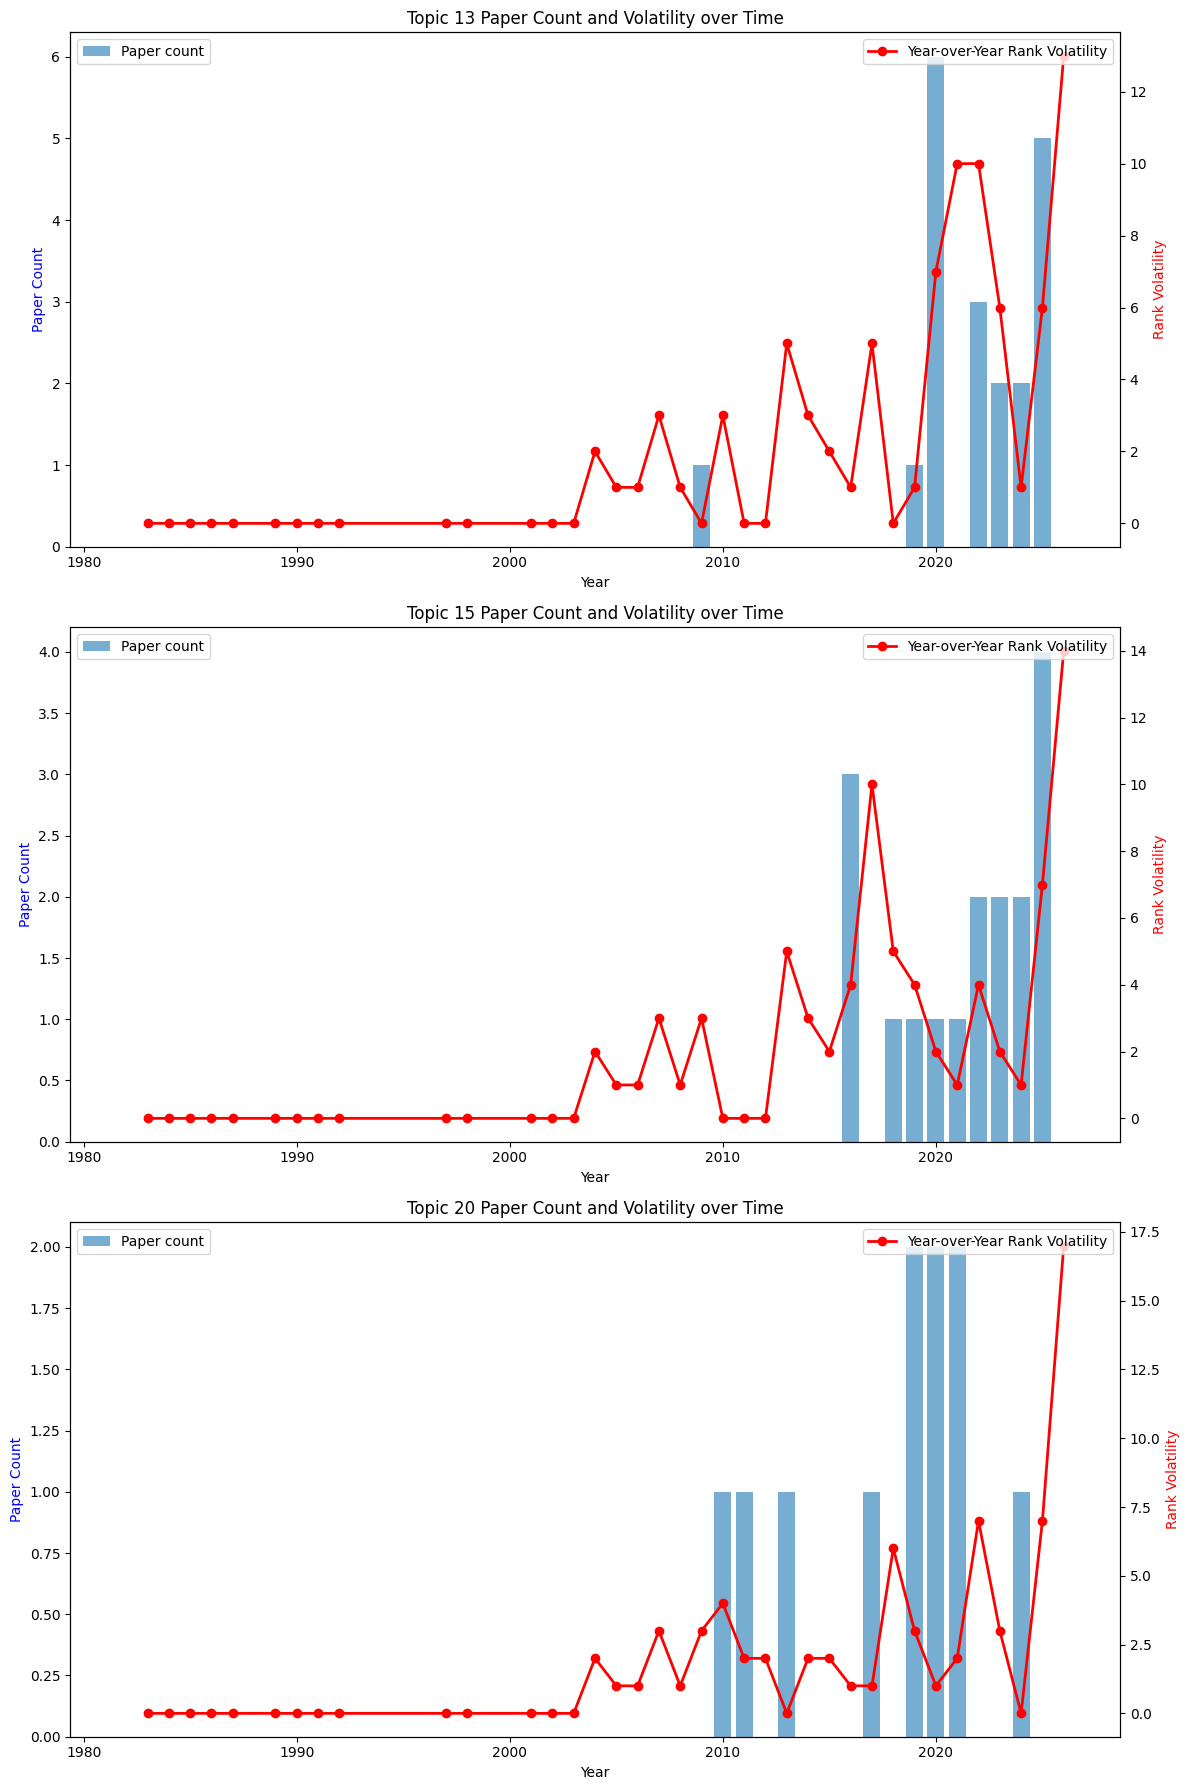

In [ ]:
import matplotlib.pyplot as plt

# Choose topics to plot (example: top 3 volatile topics)
selected_topics = most_volatile.index[:3]

fig, axs = plt.subplots(len(selected_topics), 1, figsize=(12, 6*len(selected_topics)))

if len(selected_topics) == 1:
    axs = [axs]  # Make iterable

for ax, topic in zip(axs, selected_topics):
    # Plot topic frequency over years
    ax.bar(topic_year_counts.index, topic_year_counts[topic], alpha=0.6, label='Paper count')
    ax.set_ylabel('Paper Count', color='blue')
    ax.set_xlabel('Year')
    ax.set_title(f'Topic {topic} Paper Count and Volatility over Time')

    # Twin axis for volatility
    ax2 = ax.twinx()
    ax2.plot(topic_rank_diff.index, topic_rank_diff[topic], color='red', marker='o', linewidth=2, label='Year-over-Year Rank Volatility')
    ax2.set_ylabel('Rank Volatility', color='red')

    ax.legend(loc="upper left")
    ax2.legend(loc="upper right")

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Select a topic to forecast (choose from topics you have)
topic_to_forecast = top_volatile.index[0]

# Extract yearly frequency time series for the selected topic
ts = topic_year_freq[topic_to_forecast].sort_index()

# Prepare data for LSTM: normalize and create supervised learning sequences
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(ts.values.reshape(-1,1))

def create_dataset(dataset, look_back=5):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:i+look_back, 0])
        Y.append(dataset[i+look_back, 0])
    return np.array(X), np.array(Y)

look_back = 5
X, y = create_dataset(data_scaled, look_back)
X = X.reshape((X.shape[0], X.shape[1], 1))


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(look_back, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

history = model.fit(X, y, epochs=50, batch_size=1, verbose=2)


Epoch 1/50
33/33 - 1s - 38ms/step - loss: 0.0596
Epoch 2/50
33/33 - 0s - 2ms/step - loss: 0.0532
Epoch 3/50
33/33 - 0s - 2ms/step - loss: 0.0498
Epoch 4/50
33/33 - 0s - 3ms/step - loss: 0.0491
Epoch 5/50
33/33 - 0s - 3ms/step - loss: 0.0471
Epoch 6/50
33/33 - 0s - 3ms/step - loss: 0.0455
Epoch 7/50
33/33 - 0s - 3ms/step - loss: 0.0446
Epoch 8/50
33/33 - 0s - 3ms/step - loss: 0.0443
Epoch 9/50
33/33 - 0s - 3ms/step - loss: 0.0433
Epoch 10/50
33/33 - 0s - 3ms/step - loss: 0.0440
Epoch 11/50
33/33 - 0s - 3ms/step - loss: 0.0417
Epoch 12/50
33/33 - 0s - 2ms/step - loss: 0.0407
Epoch 13/50
33/33 - 0s - 3ms/step - loss: 0.0404
Epoch 14/50
33/33 - 0s - 3ms/step - loss: 0.0391
Epoch 15/50
33/33 - 0s - 3ms/step - loss: 0.0392
Epoch 16/50
33/33 - 0s - 3ms/step - loss: 0.0397
Epoch 17/50
33/33 - 0s - 3ms/step - loss: 0.0381
Epoch 18/50
33/33 - 0s - 2ms/step - loss: 0.0384
Epoch 19/50
33/33 - 0s - 2ms/step - loss: 0.0399
Epoch 20/50
33/33 - 0s - 2ms/step - loss: 0.0375
Epoch 21/50
33/33 - 0s - 3ms

In [ ]:
def predict_future(model, data_scaled, look_back, n_steps=5):
    predictions = []
    input_seq = data_scaled[-look_back:].reshape(1, look_back, 1)
    for _ in range(n_steps):
        pred = model.predict(input_seq)[0][0]
        predictions.append(pred)
        input_seq = np.append(input_seq[:,1:,:], [[[pred]]], axis=1)
    return np.array(predictions)

n_future_years = 5
future_scaled = predict_future(model, data_scaled, look_back, n_steps=n_future_years)
future_preds = scaler.inverse_transform(future_scaled.reshape(-1,1)).flatten()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


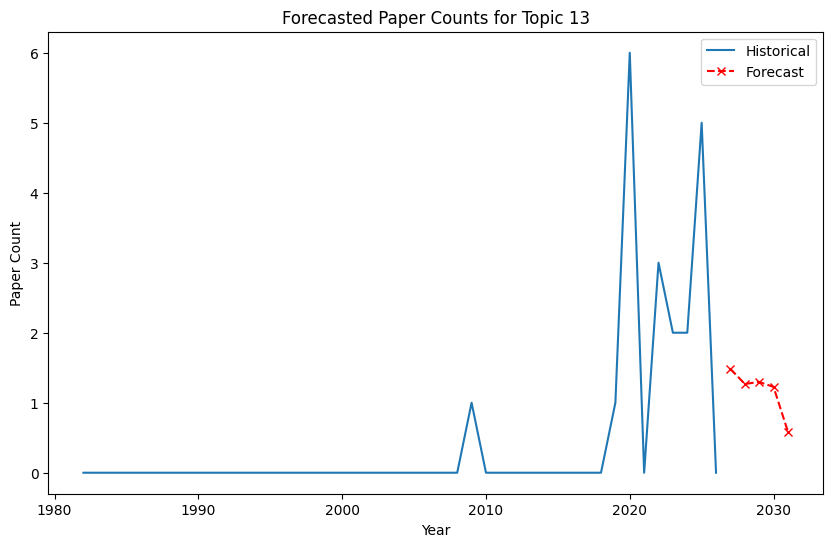

In [ ]:
import matplotlib.pyplot as plt

last_year = ts.index[-1]
future_years = [last_year + i for i in range(1, n_future_years+1)]

plt.figure(figsize=(10,6))
plt.plot(ts.index, ts.values, label='Historical')
plt.plot(future_years, future_preds, marker='x', linestyle='--', color='red', label='Forecast')
plt.title(f"Forecasted Paper Counts for Topic {topic_to_forecast}")
plt.xlabel("Year")
plt.ylabel("Paper Count")
plt.legend()
plt.show()
